---
# STEREO <a class="anchor" id="stereo-loader"></a>

- GitHub: https://github.com/serpentine-h2020/SEPpy

In [ ]:
# to do: 

# av_en SEPT, HET

# other mag loader
# implement PAD plots, implement mag angles, polarity

# mag 

#### Importing and general settings

In [ ]:
# from IPython.core.display import display, HTML
# display(HTML(data="""<style> div#notebook-container { width: 80%; } div#menubar-container { width: 85%; } div#maintoolbar-container { width: 90%; } </style>"""))
import datetime as dt
import numpy as np
import os
import pandas as pd
import warnings
import math
import cdflib
from matplotlib import pyplot as plt
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 12
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rcParams['agg.path.chunksize'] = 20000
from matplotlib import cm
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm, Normalize
from datetime import timedelta
import datetime as dt
from seppy.loader.stereo import stereo_load
from seppy.util import resample_df
from sunpy.coordinates import get_horizons_coord
from sunpy.coordinates import frames

from tools.my_func_py3 import mag_angles
from tools.polarity_plotting import polarity_rtn, polarity_panel, polarity_colorwheel
from tools.stereo_tools import load_swaves

# omit Pandas' PerformanceWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# def resample_df(df, resample):
#     """
#     Resample Pandas Dataframe
#     """
#     try:
#         # _ = pd.Timedelta(resample)  # test if resample is proper Pandas frequency
#         df = df.resample(resample).mean()
#         df.index = df.index + pd.tseries.frequencies.to_offset(pd.Timedelta(resample)/2)
#     except ValueError:
#         raise Warning(f"Your 'resample' option of [{resample}] doesn't seem to be a proper Pandas frequency!")
#     return df

#### Define some general options

In [ ]:
year = 2024
opt  = dict(#Timestamp position
            pos_timestamp = None,
            #Path to save plots
            file_path = f'{os.getcwd()}{os.sep}data',

            startdate = dt.datetime(year, 1, 14,10),
            enddate = dt.datetime(year, 1, 16, 8),

            #year = 2024
            #startdate = dt.datetime(year, 5, 13,0)
            #enddate = dt.datetime(year, 5, 14, 12)

            #year = 2023
            #startdate = X1 = dt.datetime(year, 10, 3, 0)
            #enddate = X2 = dt.datetime(year, 10, 4)

            #startdate = X1 = dt.datetime(year, 1, 18, 12, 0)
            #enddate = X2 = dt.datetime(year, 1, 19, 22)

            sc = 'A',
            plot_electrons = True,
            plot_protons = True,
            plot_pad = False,
            plot_mag_angles = True,
            plot_mag = True,
            plot_Vsw = True,
            plot_N = True,
            plot_T = True,
            plot_polarity = False,

            plot_het = True,

            plot_lines = True,

            legends_inside = False,

            resample = '20min',
            resample_mag = '1min',
            sept_viewing = 'sun' #viewing_list[0]
)

In [ ]:

#Timestamp position
opt["pos_timestamp"] = None
#Path to save plots
file_path = None


year = 2024
opt["startdate"] = X1 = dt.datetime(year, 1, 14,10)
opt["enddate"] = X2 = dt.datetime(year, 1, 16, 8)

#year = 2024
#startdate = dt.datetime(year, 5, 13,0)
#enddate = dt.datetime(year, 5, 14, 12)

#year = 2023
#startdate = X1 = dt.datetime(year, 10, 3, 0)
#enddate = X2 = dt.datetime(year, 10, 4)

#startdate = X1 = dt.datetime(year, 1, 18, 12, 0)
#enddate = X2 = dt.datetime(year, 1, 19, 22)



opt["sc"] = 'A'
opt["plot_radio"] = True
opt["plot_electrons"] = True
opt["plot_protons"] = True
opt["plot_pad"] = False
opt["plot_mag_angles"] = True 
opt["plot_mag"] = True
opt["plot_Vsw"] = True
opt["plot_N"] = True
opt["plot_T"] = True
opt["plot_polarity"] = False 

opt["plot_het"] = True

opt["plot_lines"] = True

opt["legends_inside"] = False

opt["resample"] = '20min'
opt["resample_mag"] = '1min'

#Choose every n:th channel
#het_e has only 3 channels, no choosing!
opt["n_sept_e"] = 2
opt["n_sept_p"] = 3
opt["n_het_p"] = 1

#Channels list
channels_n_sept_e = list(np.arange(0,14+1,opt["n_sept_e"]))
channels_n_het_e = list(np.arange(0,2+1,1))
channels_n_sept_p = list(np.arange(0,29+1,opt["n_sept_p"]))
channels_n_het_p = list(np.arange(0,10+1,opt["n_het_p"]))

channels_list = [channels_n_sept_e, channels_n_het_e, channels_n_sept_p, channels_n_het_p]

#Chosen channels
print('Channels:')
print('sept_e:',channels_list[0],',', len(channels_list[0]))
print('het_e:',channels_list[1],',', len(channels_list[1]))
print('sept_p:',channels_list[2],',', len(channels_list[2]))
print('het_p:',channels_list[3],',', len(channels_list[3]))

panels = 1*opt["plot_radio"] + 1*opt["plot_electrons"] + 1*opt["plot_protons"] + 1*opt["plot_pad"] + 2*opt["plot_mag_angles"] + 1*opt["plot_mag"] + 1* opt["plot_Vsw"] + 1* opt["plot_N"] + 1* opt["plot_T"]

panel_ratios = list(np.zeros(panels)+1)

if opt["plot_radio"]:
    panel_ratios[0] = 2
if opt["plot_electrons"] and opt["plot_protons"]:
    panel_ratios[0+1*opt["plot_radio"]] = 2
    panel_ratios[1+1*opt["plot_radio"]] = 2
if opt["plot_electrons"] or opt["plot_protons"]:    
    panel_ratios[0+1*opt["plot_radio"]] = 2

opt["sept_viewing"] = 'sun' #viewing_list[0]

data = {}

#### Load data

In [ ]:
data["df_sept_electrons_orig"], data["meta_se"] = stereo_load(instrument='SEPT', startdate=data["startdate"], enddate=data["enddate"], 
                        sept_species='e', sept_viewing=opt["sept_viewing"],
                        path=file_path, pos_timestamp=opt["pos_timestamp"], spacecraft=opt["sc"])
data["df_sept_protons_orig"], data["meta_sp"] = stereo_load(instrument='SEPT', startdate=data["startdate"], enddate=data["enddate"], 
                        sept_species='p', sept_viewing=opt["sept_viewing"],
                        path=file_path, pos_timestamp=opt["pos_timestamp"], spacecraft=opt["sc"])
if opt["plot_het"]:
    data["df_het_orig"], data["meta_het"] = stereo_load(instrument='HET', startdate=data["startdate"], enddate=data["enddate"],
                       path=file_path, pos_timestamp=opt["pos_timestamp"], spacecraft=opt["sc"])

if opt["plot_mag"]:
    data["df_mag_orig"], data["meta"] = stereo_load(spacecraft=opt["sc"], instrument='MAG', startdate=data["startdate"], enddate=data["enddate"], mag_coord='RTN', 
                                    path=file_path)

if opt["plot_Vsw"] or opt["plot_N"] or opt["plot_T"]:
    data["magplasma"], data["meta"] = stereo_load(instrument='MAGPLASMA', startdate=data["startdate"], enddate=data["enddate"], 
                        path=file_path, pos_timestamp=opt["pos_timestamp"], spacecraft=opt["sc"])
    
if opt["plot_radio"]:
    data["df_waves_hfr"] = load_swaves("STA_L3_WAV_HFR", startdate=data["startdate"], enddate=data["enddate"], path=file_path)
    data["df_waves_lfr"] = load_swaves("STA_L3_WAV_LFR", startdate=data["startdate"], enddate=data["enddate"], path=file_path)


2025-03-04 10:17:24 - sunpy - WARNING: SunpyUserWarning: No units provided for variable "MAGFLAGUC". Assigning dimensionless units.
2025-03-04 10:18:07 - sunpy - WARNING: SunpyUserWarning: astropy did not recognize units of "Na". Assigning dimensionless units. If you think this unit should not be dimensionless, please raise an issue at https://github.com/sunpy/sunpy/issues
2025-03-04 10:18:07 - sunpy - WARNING: SunpyUserWarning: astropy did not recognize units of "Na". Assigning dimensionless units. If you think this unit should not be dimensionless, please raise an issue at https://github.com/sunpy/sunpy/issues
2025-03-04 10:18:07 - sunpy - WARNING: SunpyUserWarning: astropy did not recognize units of "Na". Assigning dimensionless units. If you think this unit should not be dimensionless, please raise an issue at https://github.com/sunpy/sunpy/issues
2025-03-04 10:18:08 - sunpy - WARNING: SunpyUserWarning: astropy did not recognize units of "Na". Assigning dimensionless units. If you 

# time averaging (resample)

In [ ]:
if opt["resample"] is not None:
    data["df_sept_electrons"] = resample_df(data["df_sept_electrons_orig"], opt["resample"])  
    data["df_sept_protons"] = resample_df(data["df_sept_protons_orig"], opt["resample"])  
    if opt["plot_het"]:
        data["df_het"]  = resample_df(data["df_het_orig"], opt["resample"])  
    if opt["plot_Vsw"] or opt["plot_N"] or opt["plot_T"]:
        data["df_magplas"] = resample_df(data["magplasma"], opt["resample_mag"]) 
    if opt["plot_mag"]:
        data["df_mag"] = resample_df(data["df_mag_orig"], opt["resample_mag"])
   
else:
    data["df_sept_electrons"] = data["df_sept_electrons_orig"]
    data["df_sept_protons"] = data["df_sept_protons_orig"]  
    if opt["plot_het"]:
        data["df_het"]  = data["df_het_orig"]
    if opt["plot_Vsw"] or opt["plot_N"] or opt["plot_T"]:
        data["df_magplas"] = data["magplasma"]
    if opt["plot_mag"]:
        data["df_mag"] = data["df_mag_orig"]

Channels:
sept_e: [np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8), np.int64(10), np.int64(12), np.int64(14)] , 8
het_e: [np.int64(0), np.int64(1), np.int64(2)] , 3
sept_p: [np.int64(0), np.int64(3), np.int64(6), np.int64(9), np.int64(12), np.int64(15), np.int64(18), np.int64(21), np.int64(24), np.int64(27)] , 10
het_p: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] , 11


<>:166: SyntaxWarning: invalid escape sequence '\m'
<>:166: SyntaxWarning: invalid escape sequence '\m'
C:\Users\osant\AppData\Local\Temp\ipykernel_7712\3293956644.py:166: SyntaxWarning: invalid escape sequence '\m'
  axs[i].set_ylabel("N$_\mathrm{p}$ [cm$^{-3}$]", fontsize=font_ylabel)


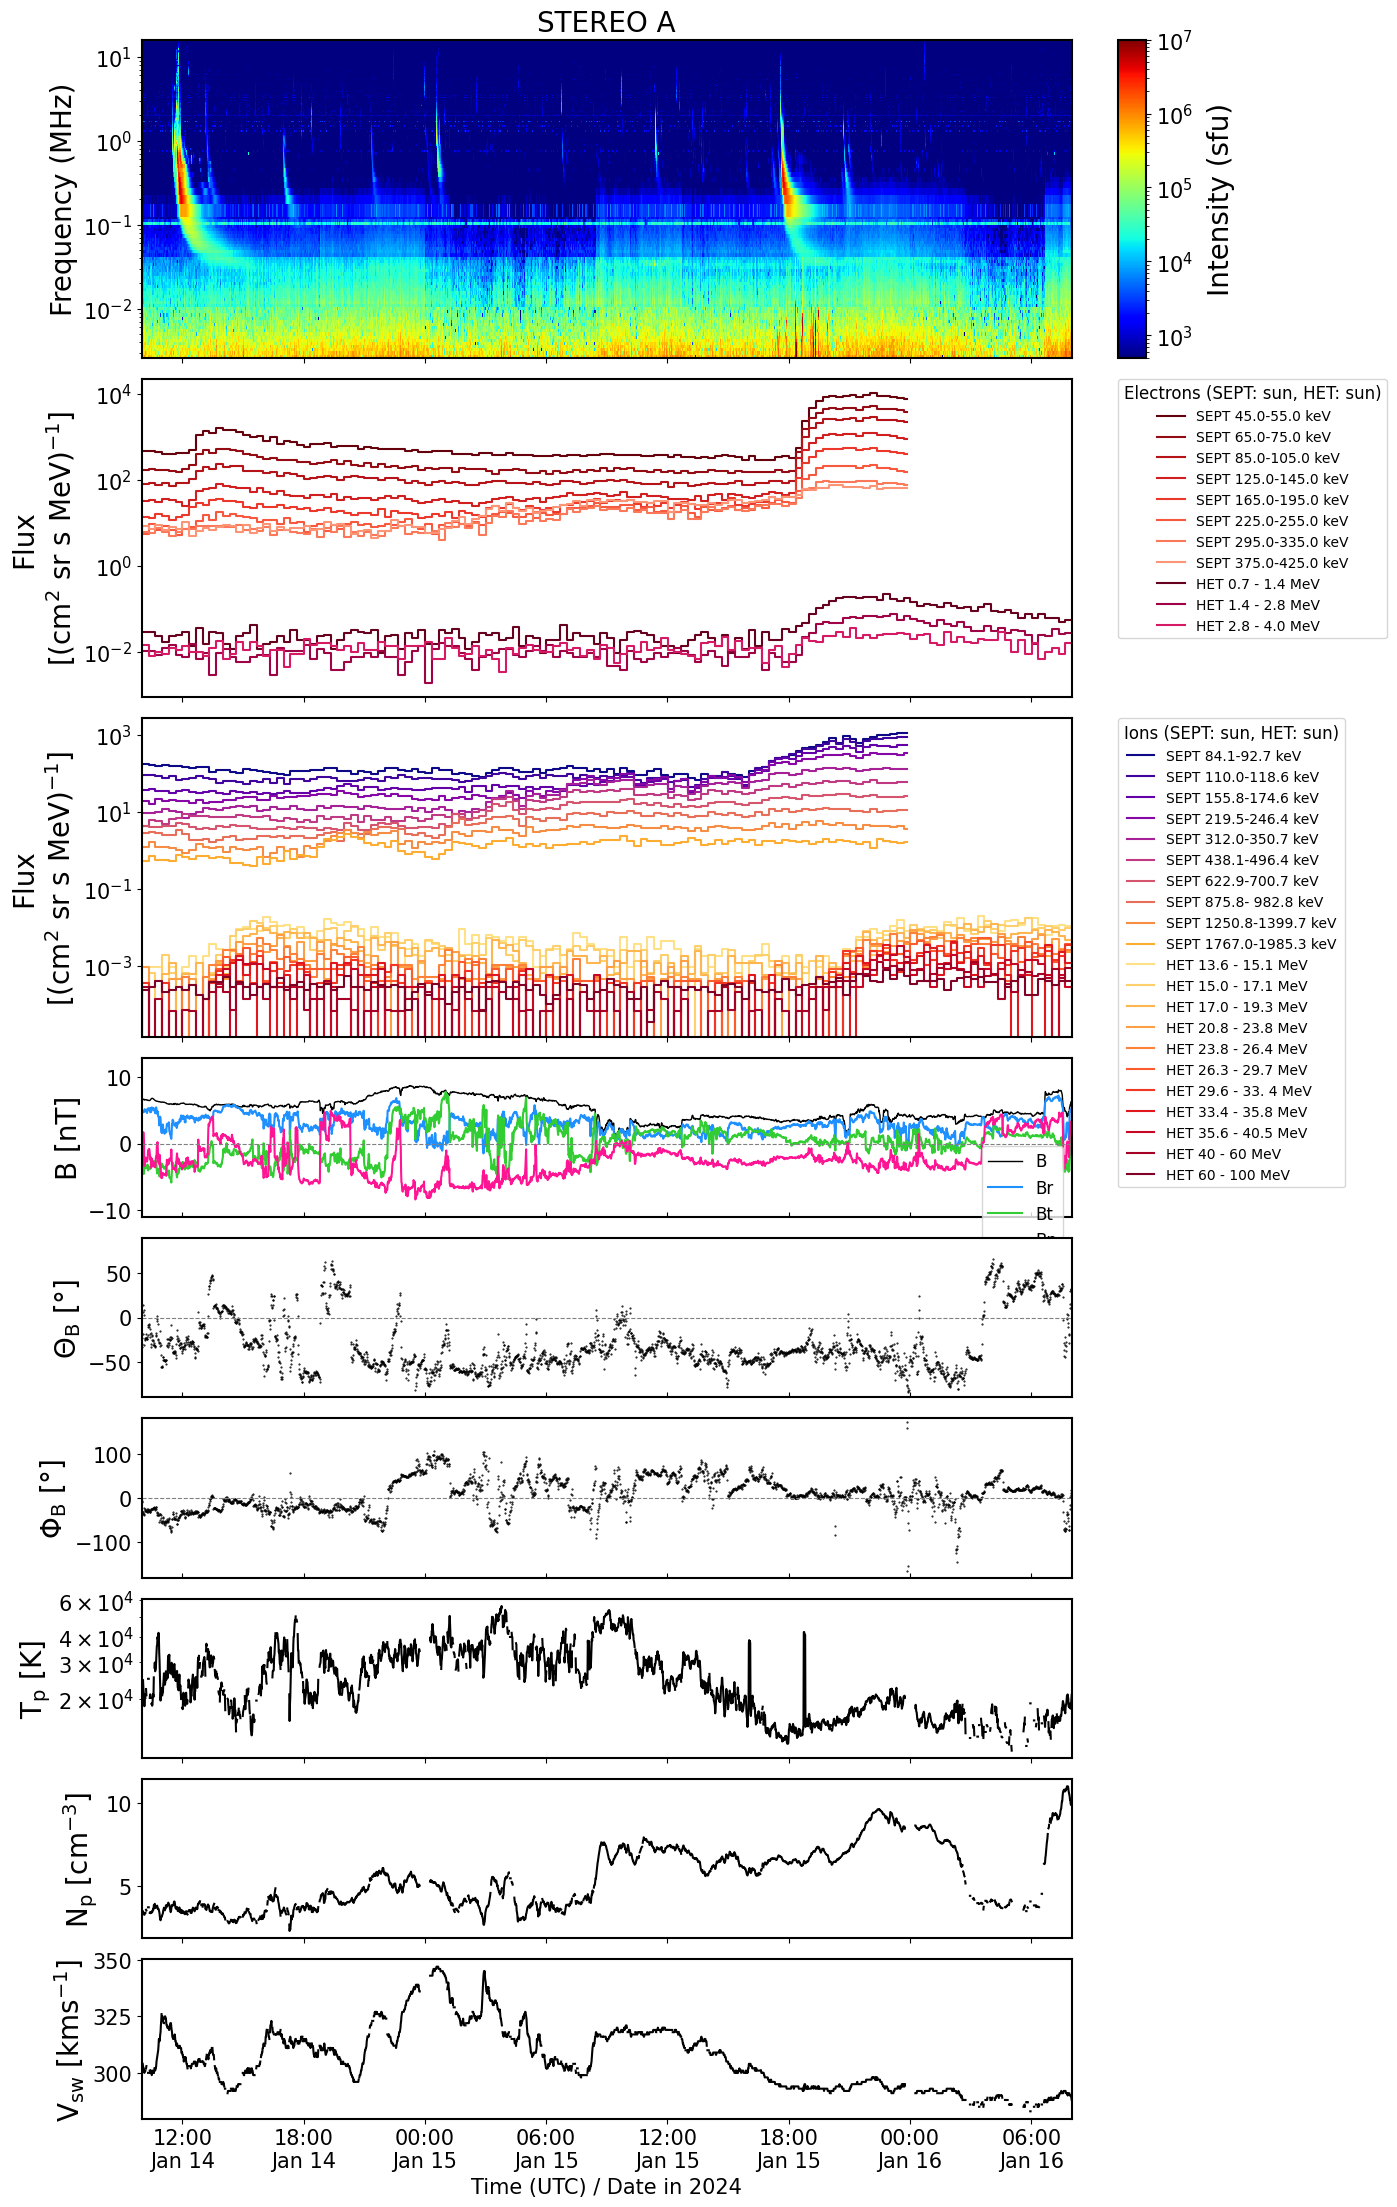

In [ ]:
#%matplotlib notebook
#%matplotlib inline

font_ylabel = 20
font_legend = 10

if panels == 3:
    fig, axs = plt.subplots(nrows=panels, sharex=True, figsize=[12, 4*panels])#, gridspec_kw={'height_ratios': panel_ratios})# layout="constrained")
else:
    fig, axs = plt.subplots(nrows=panels, sharex=True, figsize=[12, 3*panels], gridspec_kw={'height_ratios': panel_ratios})# layout="constrained")
fig.subplots_adjust(hspace=0.1)

i = 0

color_offset = 4

if opt["plot_radio"]:
    vmin, vmax = 500, 1e7
    log_norm = LogNorm(vmin=vmin, vmax=vmax)
    
    TimeHFR2D, FreqHFR2D = np.meshgrid(data["df_waves_hfr"].index, data["df_waves_hfr"].columns, indexing='ij')
    TimeLFR2D, FreqLFR2D = np.meshgrid(data["df_waves_lfr"].index, data["df_waves_lfr"].columns, indexing='ij')

    # Create colormeshes. Shading option flat and thus the removal of last row and column are there to solve the time jump bar problem, 
    # when resampling isn't used
    mesh = axs[i].pcolormesh(TimeLFR2D, FreqLFR2D, data["df_waves_lfr"].iloc[:-1,:-1], shading='flat', cmap='jet', norm=log_norm)
    axs[i].pcolormesh(TimeHFR2D, FreqHFR2D, data["df_waves_hfr"].iloc[:-1,:-1], shading='flat', cmap='jet', norm=log_norm) # TODO: check if on top

    axs[i].set_yscale('log')
    axs[i].set_ylabel("Frequency (MHz)", fontsize=font_ylabel)
    
    # Add inset axes for colorbar
    axins = inset_axes(axs[i], width="100%", height="100%", loc="center", bbox_to_anchor=(1.05,0,0.03,1), bbox_transform=axs[i].transAxes, borderpad=0.2)
    cbar = fig.colorbar(mesh, cax=axins, orientation="vertical")
    cbar.set_label("Intensity (sfu)", rotation=90, labelpad=10, fontsize=font_ylabel)
    i += 1

if opt["plot_electrons"]:
    # plot sept electron channels
    axs[i].set_prop_cycle('color', plt.cm.Reds_r(np.linspace(0,1,len(channels_list[0])+color_offset)))
    for channel in channels_list[0]:
        axs[i].plot(data["df_sept_electrons"].index, data["df_sept_electrons"][f'ch_{channel+2}'],
                    ds="steps-mid", label='SEPT '+data["meta_se"].ch_strings[channel+2])
    if opt["plot_het"]:
        # plot het electron channels
        axs[i].set_prop_cycle('color', plt.cm.PuRd_r(np.linspace(0,1,4+color_offset)))
        for channel in channels_list[1]:
            axs[i].plot(data["df_het"][f'Electron_Flux_{channel}'], 
                        label='HET '+data["meta_het"]['channels_dict_df_e'].ch_strings[channel],
                    ds="steps-mid")
    
    axs[i].set_ylabel("Flux\n"+r"[(cm$^2$ sr s MeV)$^{-1}]$", fontsize=font_ylabel)
    if opt["legends_inside"]:
        axs[i].legend(loc='upper right', borderaxespad=0., 
                  title=f'Electrons (SEPT: {opt["sept_viewing"]}, HET: sun)', fontsize=font_legend)
    else:
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
                  title=f'Electrons (SEPT: {opt["sept_viewing"]}, HET: sun)', fontsize=font_legend)
    axs[i].set_yscale('log')
    i +=1    

    
color_offset = 2    
if opt["plot_protons"]:
    # plot sept proton channels
    num_channels = len(channels_list[2])# + len(channels_list[3])
    axs[i].set_prop_cycle('color', plt.cm.plasma(np.linspace(0,1,num_channels+color_offset)))
    for channel in channels_list[2]:
        axs[i].plot(data["df_sept_protons"].index, data["df_sept_protons"][f'ch_{channel+2}'], 
                label='SEPT '+data["meta_sp"].ch_strings[channel+2], ds="steps-mid")
    
    color_offset = 0 
    if opt["plot_het"]:
        # plot het proton channels
        axs[i].set_prop_cycle('color', plt.cm.YlOrRd(np.linspace(0.2,1,len(channels_list[3])+color_offset)))
        for channel in channels_list[3]:
            axs[i].plot(data["df_het"].index, data["df_het"][f'Proton_Flux_{channel}'], 
                    label='HET '+data["meta_het"]['channels_dict_df_p'].ch_strings[channel], ds="steps-mid")
    
    axs[i].set_ylabel("Flux\n"+r"[(cm$^2$ sr s MeV)$^{-1}]$", fontsize=font_ylabel)
    if opt["legends_inside"]:
        axs[i].legend(loc='upper right', borderaxespad=0., 
                  title=f'Ions (SEPT: {opt["sept_viewing"]}, HET: sun)', fontsize=font_legend)
    else:
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
                  title=f'Ions (SEPT: {opt["sept_viewing"]}, HET: sun)', fontsize=font_legend)
    axs[i].set_yscale('log')
    i +=1    
    
    
    
    
    
    
# plot magnetic field
if opt["plot_mag"]:
    ax = axs[i]
    ax.plot(data["df_mag"].index, data["df_mag"].BFIELD_3, label='B', color='k', linewidth=1)
    ax.plot(data["df_mag"].index.values, data["df_mag"].BFIELD_0.values, label='Br', color='dodgerblue')
    ax.plot(data["df_mag"].index.values, data["df_mag"].BFIELD_1.values, label='Bt', color='limegreen')
    ax.plot(data["df_mag"].index.values, data["df_mag"].BFIELD_2.values, label='Bn', color='deeppink')
    ax.axhline(y=0, color='gray', linewidth=0.8, linestyle='--')
    if opt["legends_inside"]:
        ax.legend(loc='upper right')
    else:
        ax.legend(loc=1, bbox_to_anchor=(1, 0.5))
        
    ax.set_ylabel('B [nT]', fontsize=font_ylabel)
    ax.tick_params(axis="x", direction="in", which='both')#, pad=-15)
    i += 1
    
if opt["plot_polarity"]:
    pos = get_horizons_coord(f'STEREO-{opt["sc"]}', time={'start':data["magplasma"].index[0]-pd.Timedelta(minutes=15),'stop':data["magplasma"].index[-1]+pd.Timedelta(minutes=15),'step':"1min"})  # (lon, lat, radius) in (deg, deg, AU)
    pos = pos.transform_to(frames.HeliographicStonyhurst())
    #Interpolate position data to magnetic field data cadence
    r = np.interp([t.timestamp() for t in data["magplasma"].index],[t.timestamp() for t in pd.to_datetime(pos.obstime.value)],pos.radius.value)
    lat = np.interp([t.timestamp() for t in data["magplasma"].index],[t.timestamp() for t in pd.to_datetime(pos.obstime.value)],pos.lat.value)
    pol, phi_relative = polarity_rtn(data["magplasma"].BFIELDRTN_0.values, data["magplasma"].BFIELDRTN_1.values, data["magplasma"].BFIELDRTN_2.values,r,lat,V=400)
# create an inset axe in the current axe:
    pol_ax = inset_axes(ax, height="5%", width="100%", loc=9, bbox_to_anchor=(0.,0,1,1.1), bbox_transform=ax.transAxes) # center, you can check the different codes in plt.legend?
    pol_ax.get_xaxis().set_visible(False)
    pol_ax.get_yaxis().set_visible(False)
    pol_ax.set_ylim(0,1)
    pol_ax.set_xlim([data["df_magplas"].index.values[0], data["df_magplas"].index.values[-1]])
    pol_arr = np.zeros(len(pol))+1
    timestamp = data["df_magplas"].index.values[2] - data["df_magplas"].index.values[1]
    norm = Normalize(vmin=0, vmax=180, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
    pol_ax.bar(data["magplasma"].index.values[(phi_relative>=0) & (phi_relative<180)],pol_arr[(phi_relative>=0) & (phi_relative<180)],color=mapper.to_rgba(phi_relative[(phi_relative>=0) & (phi_relative<180)]),width=timestamp)
    pol_ax.bar(data["magplasma"].index.values[(phi_relative>=180) & (phi_relative<360)],pol_arr[(phi_relative>=180) & (phi_relative<360)],color=mapper.to_rgba(np.abs(360-phi_relative[(phi_relative>=180) & (phi_relative<360)])),width=timestamp)
    pol_ax.set_xlim(data["startdate"], data["enddate"])
    
if opt["plot_mag_angles"]:
    ax = axs[i]
    #Bmag = np.sqrt(np.nansum((mag_data.B_r.values**2,mag_data.B_t.values**2,mag_data.B_n.values**2), axis=0))    
    alpha, phi = mag_angles(data["df_mag"].BFIELD_3, data["df_mag"].BFIELD_0.values, data["df_mag"].BFIELD_1.values,
                            data["df_mag"].BFIELD_2.values)
    ax.plot(data["df_mag"].index, alpha, '.k', label='alpha', ms=1)
    ax.axhline(y=0, color='gray', linewidth=0.8, linestyle='--')
    ax.set_ylim(-90, 90)
    ax.set_ylabel(r"$\Theta_\mathrm{B}$ [°]", fontsize=font_ylabel)
    # ax.set_xlim(X1, X2)
    ax.tick_params(axis="x",direction="in", pad=-15)

    i += 1
    ax = axs[i]
    ax.plot(data["df_mag"].index, phi, '.k', label='phi', ms=1)
    ax.axhline(y=0, color='gray', linewidth=0.8, linestyle='--')
    ax.set_ylim(-180, 180)
    ax.set_ylabel(r"$\Phi_\mathrm{B}$ [°]", fontsize=font_ylabel)
    # ax.set_xlim(X1, X2)
    ax.tick_params(axis="x",direction="in", which='both', pad=-15)
    i += 1
    
### Temperature
if opt["plot_T"]:
    axs[i].plot(data["df_magplas"].index, data["df_magplas"]['Tp'], '-k', label="Temperature")
    axs[i].set_ylabel(r"T$_\mathrm{p}$ [K]", fontsize=font_ylabel)
    axs[i].set_yscale('log')
    i += 1

### Density
if opt["plot_N"]:
    axs[i].plot(data["df_magplas"].index, data["df_magplas"].Np,
                '-k', label="Ion density")
    axs[i].set_ylabel("N$_\mathrm{p}$ [cm$^{-3}$]", fontsize=font_ylabel)
    i += 1

### Sws
if opt["plot_Vsw"]:
    axs[i].plot(data["df_magplas"].index, data["df_magplas"].Vp,
                '-k', label="Bulk speed")
    axs[i].set_ylabel(r"V$_\mathrm{sw}$ [kms$^{-1}$]", fontsize=font_ylabel)
    #i += 1
      
        
#axs[-1].set_xlabel(f"Date in {year}/  Time (UTC)", fontsize=15)
#axs[-1].set_xlim(startdate, enddate)
axs[0].set_title(f'STEREO {opt["sc"]}', ha='center')
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%b %d'))
axs[-1].xaxis.set_tick_params(rotation=0)
axs[-1].set_xlabel(f"Time (UTC) / Date in {data["startdate"].year}", fontsize=15)
axs[-1].set_xlim(data["startdate"], data["enddate"])

#line = dt.datetime(year, 3, 15, 1)
line = dt.datetime(year, 3, 13, 3, 15)

plot_line = True
for ax in axs:
    #ax.tick_params(axis='both', labelsize=12)
    if opt["plot_lines"]:
        ax.axvline(x=line, color='k', linestyle='--')
#plt.tight_layout()
#fig.set_size_inches(12,15)

In [ ]:
if opt["plot_polarity"]:
    polarity_colorwheel()